<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 4
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Redes neuronales

### Carga inicial de dependencias y datos

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
#import dtreeviz
import warnings

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#Import Keras and Tensor
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.regularizers import l2

#Random Seed
np.random.seed(2)
tf.random.set_seed(2)

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Limpieza del dataset

In [2]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()

#Eliminación de columnas irrelevantes
hotels_df_mod = hotels_df.drop(['arrival_date_day_of_month', 'stays_in_weekend_nights',
                                'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

#Eliminación de filas con valores nulos
hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

#Transformación de variables numéricas a booleanas (>0 = True, 0 = False)
hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].astype(bool)

hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].astype(bool)

hotels_df_mod['babies'] = hotels_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['babies'] = hotels_df_mod['babies'].astype(bool)

hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].astype(bool)

hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].astype(bool)

hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].astype(bool)

hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].astype(bool)

#Eliminación de filas con outliers
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

#Agent sin definir es un valor válido, por lo que se reemplaza por Undefined
hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

#Arrival_date_year se pasa a string
hotels_df_mod['arrival_date_year'] = hotels_df_mod['arrival_date_year'].astype(str)

#Se crea la columna que dice si se asignó la habitación pedida
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False
hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in hotels_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    hotels_df_mod[col] = scaler.fit_transform(hotels_df_mod[[col]])

#One-hot encoding para las columnas categóricas
hotels_df_mod = pd.get_dummies(hotels_df_mod, columns=["hotel",
    "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type",
    "deposit_type", "customer_type", "agent", 'arrival_date_year'], drop_first=True)

#Se transforman las columnas booleanas en float
bool_columns = hotels_df_mod.select_dtypes(include=['bool'])
for column in bool_columns.columns:
    hotels_df_mod[column] = hotels_df_mod[column].astype('float64')

hotels_df_mod = hotels_df_mod.reindex(sorted(hotels_df_mod.columns), axis=1)

## Entrenamiento inicial del modelo

In [3]:
df_x = hotels_df_mod.drop(['is_canceled'], axis=1)
df_y = hotels_df_mod['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size= 0.7, test_size=0.30, random_state=2)

In [4]:
# Create a simple feedforward neural network
model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(df_x.columns.size,)),  # Input layer
    keras.layers.Dense(8, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')  # Output layer 
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 4016      
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
# Compile the model
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

cant_epochs=50
# Train the model
history = model.fit(x_train, y_train, epochs=cant_epochs, batch_size=32, validation_split=0.3, verbose = False, use_multiprocessing=True)

# Evaluate the model on the test dataß
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=False)
print(f'Test accuracy: {test_accuracy}')
print(f'F1 Score: {f1_score}')

Test accuracy: 0.8446906208992004
F1 Score: <function f1_score at 0x000001978E199F80>


## Matriz de Confusion y otras métricas

In [6]:
y_train_pred = model.predict(x_train, verbose=False)
y_test_pred = model.predict(x_test, verbose=False)

binary_predictions_test = (y_test_pred > 0.5).astype(int)
binary_predictions_train = (y_train_pred > 0.5).astype(int)

In [7]:
train_score = f1_score(y_train, binary_predictions_train)
test_score = f1_score(y_test, binary_predictions_test)

print("F1-Score sobre el set de entrenamiento:", round(train_score, 3))
print("F1-Score sobre el set de prueba:", round(test_score, 3))

F1-Score sobre el set de entrenamiento: 0.859
F1-Score sobre el set de prueba: 0.843


## Optimización mediante Grid Search

Híperparametros:
- Epochs
- Activation
- Optimizer

In [13]:
# Create the sklearn model for the network

def create_model(neurons=8, activation_function='relu', l_rate=0.001):

    # Create a simple feedforward neural network
    model = keras.Sequential([
    keras.layers.Dense(units=neurons, activation=activation_function, input_shape=(df_x.columns.size,), kernel_regularizer=l2(0.01)),  # Input layer
    keras.layers.Dense(units=neurons, activation=activation_function, kernel_regularizer=l2(0.01)), 
    keras.layers.Dense(1, activation='sigmoid')  # Output layer 
    ])

    model.compile(
      optimizer=keras.optimizers.SGD(learning_rate=l_rate),
      loss='binary_crossentropy',
      # metricas para ir calculando en cada iteracion o batch
      metrics=['accuracy'],
    )

    return model

In [15]:
modelo_cv = KerasClassifier(model=create_model, neurons=8, activation_function='relu', l_rate=0.001, optimizer='nadam', verbose = False, random_state=2)

params_grid = {
    
    'epochs': [50],
    'batch_size': [100],
    'neurons': [16, 32, 64],
    'activation_function':['relu', 'lineal'],
    'l_rate': [0.1, 0.01, 0.001]
}

scorer_fn = make_scorer(f1_score)
kfoldcv = StratifiedKFold(n_splits=5)

gridcv = GridSearchCV(estimator=modelo_cv,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred)
print("Parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/franciscolabollita/Library/Python/3.8/lib/python/site-packages/scikeras/wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/Users/franciscolabollita/Library/Python/3.8/lib/python/site-pac

Parámetros: {'activation_function': 'relu', 'batch_size': 100, 'epochs': 50, 'l_rate': 0.01, 'neurons': 64} 
F1 score:  0.831


### Métricas de mejor modelo

Matriz de confusión de los datos de prueba
F1-Score sobre el set de entrenamiento: 0.788
F1-Score sobre el set de prueba: 0.782


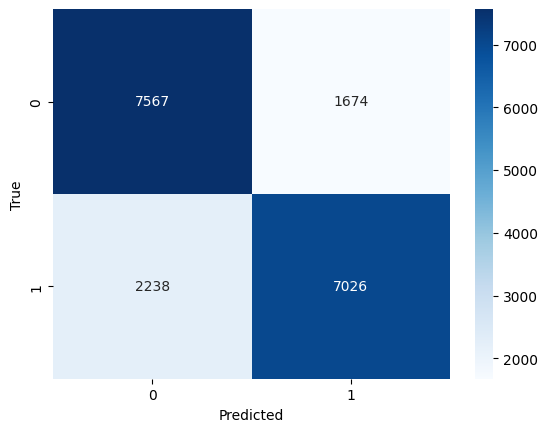

In [10]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

binary_predictions_test = (y_test_pred > 0.5).astype(int)
binary_predictions_train = (y_train_pred > 0.5).astype(int)

train_score = f1_score(y_train, binary_predictions_train)
test_score = f1_score(y_test, binary_predictions_test)

print("Matriz de confusión de los datos de prueba")
cm = confusion_matrix(y_test, binary_predictions_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print("F1-Score sobre el set de entrenamiento:", round(train_score, 3))
print("F1-Score sobre el set de prueba:", round(test_score, 3))

In [11]:
accuracy=accuracy_score(y_train, y_train_pred)
recall=recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
precision=precision_score(y_train, y_train_pred)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_train, y_train_pred))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.795
Recall:  0.763
Precision:  0.815
F1 score:  0.788
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80     21559
         1.0       0.81      0.76      0.79     21617

    accuracy                           0.79     43176
   macro avg       0.80      0.79      0.79     43176
weighted avg       0.80      0.79      0.79     43176



In [12]:
accuracy=accuracy_score(y_test,y_test_pred)
recall=recall_score(y_test,y_test_pred)
f1=f1_score(y_test,y_test_pred)
precision=precision_score(y_test,y_test_pred)

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_test, y_test_pred))

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.789
Recall:  0.758
Precision:  0.808
F1 score:  0.782
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      9241
         1.0       0.81      0.76      0.78      9264

    accuracy                           0.79     18505
   macro avg       0.79      0.79      0.79     18505
weighted avg       0.79      0.79      0.79     18505



## Predicción de hotels_test

Se modifica el dataset de test de manera similar al de train, para que el modelo obtenido pueda ser aplicado.

In [13]:
test_df = pd.read_csv('hotels_test.csv')
test_df_mod = test_df.copy()

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False
test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

test_df_mod['agent'] = test_df_mod['agent'].astype(str)

id_backup = test_df_mod[['id']].copy()

test_df_mod = test_df_mod.drop(['arrival_date_day_of_month', 'stays_in_weekend_nights',
                                'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

#Arrival_date_year se pasa a string
test_df_mod['arrival_date_year'] = test_df_mod['arrival_date_year'].astype(str)

#Transformación de variables numéricas a booleanas 
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].astype(bool)

test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].astype(bool)

test_df_mod['babies'] = test_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
test_df_mod['babies'] = test_df_mod['babies'].astype(bool)

test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].astype(bool)

test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].astype(bool)

test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].astype(bool)

test_df_mod['booking_changes'] = test_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
test_df_mod['booking_changes'] = test_df_mod['booking_changes'].astype(bool)

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in test_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    test_df_mod[col] = scaler.fit_transform(test_df_mod[[col]])

#One-hot encoding para las columnas categóricas
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country",
    "market_segment","distribution_channel", "assigned_room_type", "deposit_type", "customer_type",
    "agent", "arrival_date_year" ], drop_first=True)

#Se crean las columnas que están en el df para entrenar pero no en el df a predecir
for col in df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

# Convert the 'bool' columns to 'float64'
bool_columns = test_df_mod.select_dtypes(include=['bool'])
for column in bool_columns.columns:
    test_df_mod[column] = test_df_mod[column].astype('float64')

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

In [14]:
#Se realiza una predicción sobre test utilizando el modelo
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred.astype(int)

predictions.to_csv('sample_submission.csv', index=False)